# Analyzing LinkedIn Company Posts with Graphs and Agents

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

This notebook will analyze [NeuML's LinkedIn company posts](https://hf.co/datasets/neuml/neuml-linkedin-202501) over the last 12 months as of January 2025. It will build an embeddings database with an associated graph and topic modeling. The most popular topics will be explored using graphs and vector search queries.

From there we'll use Agents to investigate the dataset and find ways to increase engagement with our future posts using past history.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[agent,graph] datasets autoawq autoawq-kernels

# LinkedIn Company Posts

The next section builds the LinkedIn company posts dataset for NeuML. First, it downloads the company posts dataset then it creates an embeddings database.

There is also custom logic to create topic names for the generated topic clusters vs the standard naming method.

_If you'd like to instead use your own company posts, see these [steps on the dataset page](https://hf.co/datasets/NeuML/neuml-linkedin-202501)._

In [ ]:
from datasets import load_dataset
from tqdm.auto import tqdm
from txtai import Embeddings, LLM

def title(text):
    prompt = f"""
Create a simple, concise topic for the following text. Only return the topic name.

Text:
{text}
"""

    return llm([{"role": "user", "content": prompt}], maxlength=2048)

def data():
    for x in posts:
        x["url"] = x.pop("Post link")
        x["text"] = x.pop("Post title")
        x["id"] = title(x["text"])
        yield {k.lower().replace(" ", ""): v for k, v in x.items()}

posts = load_dataset("neuml/neuml-linkedin-202501", split="train")

llm = LLM("hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4")

embeddings = Embeddings(
    autoid="uuid5",
    path="intfloat/e5-large",
    instructions={"query": "query: ", "data": "passage: "},
    content=True,
    functions = [
        {"name": "graph", "function": "graph.attribute"}
    ],
    expressions = [
        {"name": "topic", "expression": "graph(indexid, 'topic')"}
    ],
    graph={
        "approximate": False,
        "topics": {"resolution": 6}
    },
)
embeddings.index(tqdm(data(), total=len(posts)))

Now that the embeddings database is built, let's generate the topic names using an LLM.

In [ ]:
def topic(text):
    prompt = f"""
Create a simple, concise topic for the following text. Only return the topic name.

Text:
{text}"""

    return llm([{"role": "user", "content": prompt}], maxlength=5000)

topics = {}
for name, nodes in tqdm(embeddings.graph.topics.items()):
    name = topic("\n".join(embeddings.graph.attribute(x, "text") for x in nodes))
    topics[name] = nodes

    # Set topic on each node
    for node in nodes:
        embeddings.graph.addattribute(node, "topic", name)

embeddings.graph.topics = topics

Both of the sections above should run within a minute with a modern GPU. Building the embeddings database and generating the topics can optionally be skipped using the following model from the Hugging Face Hub.

```python
embeddings = Embeddings()
embeddings.load(provider="huggingface-hub", container="neuml/txtai-neuml-linkedin")
```

# Popular topics

Now that we have an embeddings database, graph and topics, let's explore the data! The next section shows the Top 5 posts for each of the Top 5 most popular topics.

In [4]:
from IPython.display import display, Markdown

# Get top 5 topics by popularity
popular = embeddings.search("SELECT topic FROM txtai GROUP BY topic ORDER BY sum(impressions) DESC LIMIT 5")

output = ""
for topic in popular:
    topic = topic["topic"]
    output += f"#### {topic}\n"
    results = embeddings.search(
        "SELECT text, createddate, impressions FROM txtai WHERE topic = :topic ORDER BY impressions DESC LIMIT 5",
        parameters={"topic": topic}
    )

    for i, x in enumerate(results):
        text = x["text"].replace("\n", " ")
        output += f"{i + 1}. _{x['createddate']} - {x['impressions']} views_ - {text}\n"

display(Markdown(output))

#### Graph RAG
1. _06/09/2024 - 2567 views_ - Knowledge Graphs (KGs) are a 🔥 topic now. But how do you build them? Check out this article that uses embeddings models to automatically build a semantic graph. And it's multimodal!  https://lnkd.in/eMsAXarn 
2. _03/10/2024 - 2356 views_ - One powerful feature of txtai is that graphs can be automatically created using semantic similarity. Did you know that relationships can also be manually loaded using techniques such as relationship extraction with LLMs?  Check out this article on building knowledge graphs with LLMs and txtai.  https://lnkd.in/dBy_H4C2
3. _06/16/2024 - 2141 views_ - Want to use LLMs to automatically extraction entity-relationship models? And  load them into a knowledge graph? Then check out this article.  https://lnkd.in/dBy_H4C2
4. _03/05/2024 - 1803 views_ - Curious about Graph RAG? Did you know that txtai has an ready-to-use Embeddings graph database for popular Wikipedia articles on the HF Hub?  https://lnkd.in/e3fPr6fd
5. _03/05/2024 - 1803 views_ - 📈 Let's talk about Graph RAG. We've been looking at graph-based approaches for context generation since 2022. The best use case we've seen for Graph RAG is for more complex questions and research. For example, think of a problem as a road trip with multiple stops. A graph path traversal is a great way to pick up various concepts as context, concepts which may not be directly related and not picked up by a simple keyword/vector search.  The attached image shows two graph path traversal examples. The first shows the path between a squirrel and the Red Sox winning the world series. The 2nd shows an image path from a person parachuting and someone holding a french horn. Note the progression of both the text and images along the way. There is also another example of traversing history from the end of the Roman Empire to the Norman Conquest of England.  For problems like this, graphs do a great job. If the answer is a simple retrieval of a single entry, Graph RAG doesn't add much value. Like all things, Graph RAG isn't the be-all and end-all.  Read more in the articles below.  Semantic Graph Intro: https://lnkd.in/eMsAXarn Graph RAG: https://lnkd.in/d-BSjuj7
#### Vector Embeddings Innovations
1. _02/24/2024 - 7202 views_ - 🚀 Excited to release an updated version of PubMedBERT Embeddings with Matryoshka Representation Learning support! With this model, dynamic embeddings sizes of 64, 128, 256, 384 and 512 can be used in addition to the full size of 768. It's a great way to save space with a relatively low level of accuracy tradeoff.  Thank you to Tom Aarsen, Philipp Schmid and the Hugging Face team for adding this feature to Sentence Transformers!  https://lnkd.in/edNYMyrF
2. _10/21/2024 - 4042 views_ - Running an embeddings database with limited compute? Model2Vec is a technique to turn any sentence transformer into a really small static model.  The next release of txtai will have support for this new vectorization method!  Example txtai code: https://lnkd.in/eFSdT7B5 GitHub Project: https://lnkd.in/eEpWxZx8 Blogpost: https://lnkd.in/e4iPg4wi
3. _01/03/2025 - 2850 views_ - 🧬⚕️🔬 What if we said you can have a competitive 8 million parameter model that can index as fast as BM25? Or a 100K parameter 200KB model that retains knowledge?  We're excited to release static PubMedBERT Embeddings models! These are a set of static models distilled with the great Model2Vec library by The Minish Lab Thank you to Stéphan Tulkens and Thomas van Dongen for creating Model2Vec!  https://lnkd.in/esgtC_2X
4. _03/17/2024 - 2651 views_ - We're seeing a lot of progress with methods to improve the efficiency of vector embeddings generation. For example, vector models trained with Matryoshka Representation Learning, push the most important information to the front of the vector, enabling us to only keep a portion of an embeddings vector.  Another method, quantization, compresses the number of values that can be represented by each bucket in an embeddings vector. With binary quantization, the values can even be reduced down to a single bit.  While all this is exciting, how do we know that these methods will work well enough for our requirements? We have to test it of course! The BEIR evaluation framework has a number of sources and it's easy to add new custom sources to test. Check out this article for a full example on this topic.  https://lnkd.in/db5Jx_fE
5. _03/01/2024 - 1722 views_ - Would you trade 1% of accuracy to only have to store 1% of the data?  Exciting to see the innovation happening in the vector space and we're not talking about 1.58-bit LLMs.  With Matryoshka Embeddings, we can drastically reduce vector dimensionality while maintaining a strong level of accuracy. Check out this example that combines Matryoshka Embeddings with Faiss 4-bit scalar quantization 🚀
#### Text Summarization with txtai
1. _05/20/2024 - 2703 views_ - LLMs can translate and summarize but that doesn't mean they should. Check out this simple summarization method that's still quite popular.  https://lnkd.in/dM6XB_Rc 
2. _04/01/2024 - 2605 views_ - 🚀 We're excited to announce a new 500M parameter model 🌌 Space Time LLM.   Recent breakthroughs in LLMs have resulted in an uncanny and game changing ability to predict future outcomes. Impressive advances in quantization and compression such as 1-bit LLMs have contributed to this phenomenal breakthrough in predictive capabilities. This model redefines our understanding of what and how LLMs learn.  Check out this model and see what you can predict today!  https://lnkd.in/exdy4R5G 
3. _07/09/2024 - 1884 views_ - 🤔 Machine translation just ask a LLM to do it?  While LLMs can translate that doesn't mean they should. What if we could utilize smaller models that were trained to translate between specific languages? What if there was a pipeline that automatically loads models based on the source to target language?   🚀 Enter txtai's translation pipeline! The Translation pipeline automatically detects languages and searches the Hugging Face Hub for the best specialized model to perform the translation. These specialized models are often smaller than LLMs and much faster.   Link to code: https://lnkd.in/eefCwRDu
4. _07/11/2024 - 1710 views_ - We often hear one say they have a LLM and they want to solve a problem. LLMs aren't always the best tool for the job. Let's take text classification using a sentiment dataset.  Running LLM prompts for this dataset only leads to 58% accuracy! Training with a 4.4M parameter model has 91% accuracy. BERT is 93%. Sure we can fine-tune the LLM for this task but why spend an hour vs 8 minutes?  Be willing to accept the simpler solution.  Link to code: https://lnkd.in/d38xBm6X
5. _07/07/2024 - 1326 views_ - 🗎 Want to summarize webpages, word documents, PDFs and more? Did you know there are models pre-built for summarization that pre-date the latest LLMs? And that they do a decent job and are faster?   txtai supports pre-trained summarization models and LLMs for summarization. Either can be run as Python workflows or FastAPI services.  Link to code: https://lnkd.in/emg4QUfm 
#### txtai Vector Search Performance
1. _07/07/2024 - 2393 views_ - ✨ Let's build on our previous BM25 post and take tokenization into account. We'll compare LangChain's BM25 retriever, the recently released bm25s library (built with Scipy sparse matrices) and txtai. We'll use the same tokenization method for all 3, the Unicode Text Segmentation algorithm (UAX 29). Keep in mind that this is relevant to those using hybrid search (vector + keyword).  1.6M ArXiv abstracts were evaluated. txtai's index time was slower but search times were significantly faster. txtai used almost 6x less RAM.  Link to code: https://lnkd.in/ekSxN9pJ
2. _07/05/2024 - 2096 views_ - ⚡ LangChain and LlamaIndex both use the Rank-BM25 library to provide in-line BM25 document retrieval. Rank-BM25 is a great way to quickly stand up a BM25 search index for a small number of documents. But it doesn't scale as it's built to run in memory.  txtai has it's own BM25 implementation in Python. Term vectors are built harnessing the native performance of the Python arrays package. These term vectors are stored in a SQLite database. LRU caching stores frequently used vectors in memory. This combination of factors enables a highly performant index.  For this comparison, 2.3M ArXiv abstracts were used. LangChain ran out of memory (32 GB of RAM). The test was scaled to 1.6M abstracts. txtai had 2x slower index times but 13x faster search times than LangChain. LangChain used 25 GB of RAM, txtai used 3.8 GB of RAM.  Link to code: https://lnkd.in/eD7qn6qn
3. _07/05/2024 - 1673 views_ - 💥⚾ BM25 continues to be a heavy hitter in the information retrieval space. Did you know that txtai has a BM25 component built for speed💨?   BM25 term vectors are built harnessing the native performance of the Python arrays package. These term vectors are stored in a SQLite database. LRU caching stores frequently used vectors in memory. This combination of factors enables a highly performant index.   https://lnkd.in/eA3ui6cQ
4. _07/01/2024 - 1095 views_ - ⚡ Faiss is a great vector indexing library. It has so many features past just a flat index. txtai automatically creates a performant Faiss index scaled by the size of the incoming data. The index type can also be fully customized with configuration. This shows the power of a full-featured and long-standing integration.  See how this compares to LlamaIndex: https://lnkd.in/eWqU5z3U
5. _07/03/2024 - 747 views_ - 💥 Hnswlib is a great vector indexing library. It's integrated into a number of vector databases.  txtai utilizes the same core pipeline for generating embeddings and storing vectors regardless of the end components. There has been a careful focus in building a highly performant and efficient vector database implementation that runs great locally.  txtai uses mmap-ing and other techniques to ensure that memory limits are respected. Streaming vector generation and offloading those vectors during index creation allows txtai to build large local indexes whereas other implementations run out of memory.   See how this compares to Chroma DB (txtai is 3x faster for the same dataset): https://lnkd.in/eY_nMA85
#### txtai Community Updates
1. _02/21/2024 - 1322 views_ - 🕒 The countdown to txtai 7.0 is on. In the meantime, checkout this notebook with the code showing how all these graphs you've seen work!  https://lnkd.in/dBy_H4C2
2. _04/09/2024 - 1046 views_ - Check out this interesting article that uses txtai to solve crossword puzzles.  https://lnkd.in/ewdqZWzi
3. _03/22/2024 - 908 views_ - 🔥 Excellent tutorial on building a product search engine with txtai from NeuralNine!  https://lnkd.in/e8xsvbm2
4. _03/24/2024 - 628 views_ - Nice video covering how to build an AI Search engine with txtai.  https://lnkd.in/e2NGemzv  Check out the NeuML YouTube channel for links to this video and more: https://lnkd.in/e9cJQ79k
5. _02/28/2024 - 605 views_ - ICYMI: Check out what's new in txtai 7.0  https://lnkd.in/efuQipp9 


And lets also look at the top 5 most popular posts overall.

In [46]:
output = ""
for i, x in enumerate(embeddings.search("SELECT id, text, createddate, impressions FROM txtai ORDER BY impressions DESC", 5)):
    text = x["text"].replace("\n", " ")
    output += f"{i + 1}. _{x['createddate']} - {x['impressions']} views_ - {text}\n"

display(Markdown(output))

1. _02/24/2024 - 7202 views_ - 🚀 Excited to release an updated version of PubMedBERT Embeddings with Matryoshka Representation Learning support! With this model, dynamic embeddings sizes of 64, 128, 256, 384 and 512 can be used in addition to the full size of 768. It's a great way to save space with a relatively low level of accuracy tradeoff.  Thank you to Tom Aarsen, Philipp Schmid and the Hugging Face team for adding this feature to Sentence Transformers!  https://lnkd.in/edNYMyrF
2. _12/28/2024 - 5229 views_ - 💥 Surprise! One last release in 2024.   🧬⚕️🔬 This time it's paperai and paperetl 2.3. paperai is a semantic search and workflow application for medical/scientific papers. paperetl is a companion library for parsing papers.  This update enables the latest txtai features and fixes some long standing bugs. More to come in 2025 and maybe one more thing in 2024!  paperai: https://lnkd.in/egFSSP4 paperetl: https://lnkd.in/ecuuVG2
3. _10/21/2024 - 4042 views_ - Running an embeddings database with limited compute? Model2Vec is a technique to turn any sentence transformer into a really small static model.  The next release of txtai will have support for this new vectorization method!  Example txtai code: https://lnkd.in/eFSdT7B5 GitHub Project: https://lnkd.in/eEpWxZx8 Blogpost: https://lnkd.in/e4iPg4wi
4. _01/03/2025 - 2850 views_ - 🧬⚕️🔬 What if we said you can have a competitive 8 million parameter model that can index as fast as BM25? Or a 100K parameter 200KB model that retains knowledge?  We're excited to release static PubMedBERT Embeddings models! These are a set of static models distilled with the great Model2Vec library by The Minish Lab Thank you to Stéphan Tulkens and Thomas van Dongen for creating Model2Vec!  https://lnkd.in/esgtC_2X
5. _05/20/2024 - 2703 views_ - LLMs can translate and summarize but that doesn't mean they should. Check out this simple summarization method that's still quite popular.  https://lnkd.in/dM6XB_Rc 


A couple themes are shown in the data. Posts covering `Graph RAG`, `Vector Embeddings Innovations` and `medical literature related models` all had high engagement.

Let's plot a subgraph of the nodes related to `medical literature`.

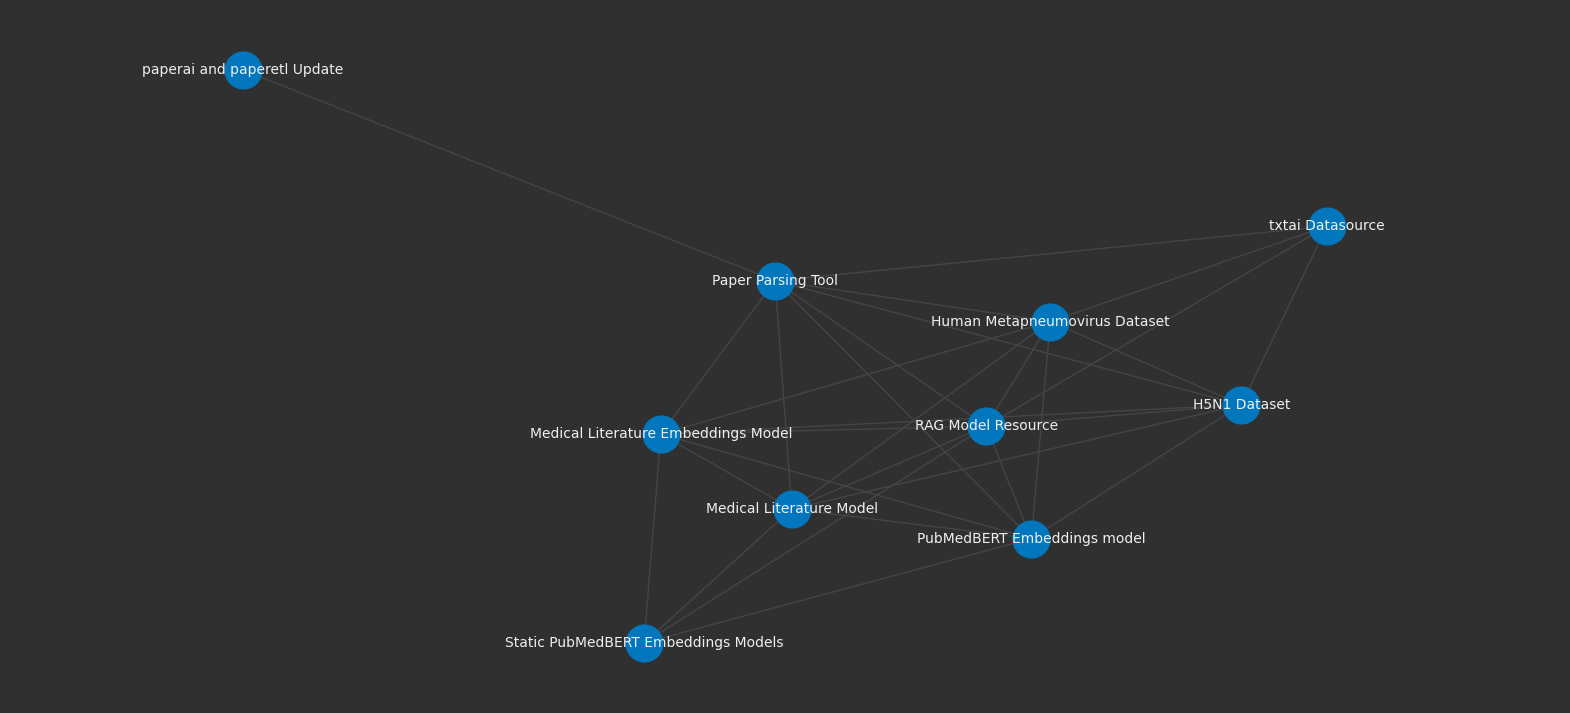

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')}" for x in graph.scan()}

    options = {
        "node_size": 700,
        "node_color": "#0277bd",
        "edge_color": "#454545",
        "font_color": "#efefef",
        "font_size": 10,
        "alpha": 1.0,
    }

    # Draw graph
    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, labels=labels, **options)

    # Disable axes and draw margins
    ax.axis("off")
    plt.margins(x=0.15)

    # Set background color
    ax.set_facecolor("#303030")
    fig.set_facecolor("#303030")

    plt.show()

plot(embeddings.search("medical literature", 10, graph=True))

# Explore the data with Agents

Our last task will use Agents to explore the dataset. We'll create a method to search the dataset with a vector query and return the matches plus post engagement (impressions, likes, clicks etc). Then we'll hand the keys over the the agent and see what it can do.

In [7]:
from txtai import Agent

def search(query):
    """
    Searches a database of posts. Returns results ordered by most popular

    Make sure to call this tool only with a string input, never use JSON.    

    Args:
        query: concepts to search for using similarity search
 
    Returns:
        list of search results with (text, impressions, likes, clicks and post urls) for each match
    """

    return embeddings.search(
        "SELECT text, impressions, likes, clicks, url FROM txtai WHERE similar(:query) ORDER BY impressions DESC",
        10, parameters={"query": query}
    )

def md(output):
    display(Markdown(output))

agent = Agent(
    tools=[search],
    llm=llm,
    max_iterations=15,
)

First, let's ask the agent to explore ways to increase engagement with future social media posts.

In [31]:
prompt = """
Analyze ALL available posts and find the topics discussed in the most popular posts.

With those findings, tell me some ideas to write about in my future social media
posts in a couple sentences.
"""

md(agent(prompt, maxlength=16000))

======== New task ========

Analyze ALL available posts and find the topics discussed in the most popular posts.

With those findings, tell me some ideas to write about in my future social media
posts in a couple sentences.

=== Agent thoughts:
Thought: I will use the tool'search' to analyze the most popular posts and find the topics discussed in them.
>>> Calling tool: 'search' with arguments: most popular posts
=== Agent thoughts:
Thought: I will now extract the topics discussed in the most popular posts.
>>> Calling tool: 'search' with arguments: txtai, RAG, Embeddings graph database, PubMedBERT, vector databases, semantic search apps, medical literature, Hacker News, GitHub, vector databases, open-source frameworks
=== Agent thoughts:
Thought: I will now extract the topics discussed in the most popular posts.
>>> Calling tool: 'search' with arguments: txtai, RAG, embeddings database, Wikipedia, vector databases, semantic search, LLM orchestration, language model workflows, Graph RA

Future social media post ideas: 1) Explore the power of Graph RAG and its applications in knowledge graph construction. 2) Discuss the benefits of using txtai's embeddings database for semantic search, LLM orchestration, and language model workflows. 3) Share success stories of using RAG for retrieval augmented generation and its potential in various industries. 4) Introduce the concept of autonomous agents and their potential in multi-model workflows. 5) Highlight the importance of open access to underlying data in a programmatic and platform-independent way.

🚀 Interesting and certainly seems in line with our own previous analysis.

Next, let's ask the agent to tell us what it knows about NeuML. This is an example of `Agentic RAG`. It is like standard RAG but it enables an LLM to have multiple passes at the knowledge base before generating the response.

In [37]:
md(agent("What would you say NeuML's core competencies are?", maxlength=16000))

======== New task ========
What would you say NeuML's core competencies are?
=== Agent thoughts:
Thought: I will use the tool `search` to find the core competencies of NeuML. The tool can search a database of posts and return results ordered by most popular.
>>> Calling tool: 'search' with arguments: NeuML core competencies
=== Agent thoughts:
Thought: The results from the search tool indicate that NeuML's core competencies include:

- Generative knowledge graphs
- Micromodels
- Cloud offering
- Consulting services
- Community engagement and training

However, it's not clear what NeuML's core competencies are from the search results. Let me try to find more information.
>>> Calling tool: 'search' with arguments: NeuML core competencies
=== Agent thoughts:
Thought: The search results still don't clearly indicate NeuML's core competencies. However, it seems that NeuML is building a sustainable and profitable company from the start and provides consulting services in situations where it's

NeuML provides a range of services, including consulting, advisory and strategic support services (i.e. Fractional CTO), open-source development, and more.

Seems about right. Let's keep in mind this is using a database of company posts, so it only knows what the company tells it to know 😂.

Next, lets see what the agent believes are the strengths of txtai.

In [44]:
md(agent("Tell me about the strengths of txtai", maxlength=16000))

======== New task ========
Tell me about the strengths of txtai
=== Agent thoughts:
Thought: I will use the tool `search` to find information about the strengths of txtai.
>>> Calling tool: 'search' with arguments: txtai strengths
=== Agent thoughts:
Thought: The strengths of txtai include its ability to automatically create graphs using semantic similarity, as well as its robust integration with Postgres, which allows for the persistence of vectors, sparse vectors, documents, graph edges, and nodes. Additionally, txtai has a growing ease of use, with a well-documented project and reliable, easy-to-use features out of the box. It also supports a variety of integrations, including Agents, RAG, and Vector Search, and has a focus on security with full Postgres integration.

Thought: I also noticed that txtai has a focus on depth over breadth, ensuring that integrations are performant and support a large number of the underlying libraries' features. It is also built on the shoulders of ope

txtai's strengths include its ability to automatically create graphs using semantic similarity, robust integration with Postgres, ease of use, variety of integrations, focus on security, focus on depth over breadth, and commitment to open access to underlying data.

Remember, this is based on what posts received the most impressions. It's a feedback loop with what users on LinkedIn believe is a strength as most engaging posts are prioritized. This is a complex topic as engagement is also driven by what LinkedIn chooses to share in user's feeds, which no one really knows the answer to 😀.

# Wrapping up

This notebook demonstrated how to use graphs and agents to explore the [NeuML LinkedIn Posts dataset](https://huggingface.co/datasets/neuml/neuml-linkedin-202501). It presented ideas on how to increase future social media engagement by analyzing what's worked in the past. It was very illuminating 💡.